In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Markov Chain Monte Carlo

You wake up on a cold, damp, hard floor. Everything is covered in darkness, such that you can't even see your hand an inch from your face. You begin to slowly crawl forward, feeling the ground as you go. You notice the floor is strangely uneven, but you continue crawling randomly until you eventually collide with a wall. You turn and continue crawling for what seems like hours until you have a near perfect image of the floor in your mind. You know where the center of the room is, where the floor is steep and where the floor is level. You know it so well, that the darkness has become irrelevant to your mental topographic map of the room. In essence, you have just performed MCMC on the terrain of your mysterious enclosure. 

The spirit of MCMC is accepting the intractability of directly obtaining the posterior, and instead  randomly walking across the posterior. Along the way, you record your random steps, and before you know it, you have a solid approximation of the posterior. 

### What is Monte Carlo?

The Monte Carlo method is a quick and dirty method for approximating a numerical problem with random simulation.

Example: Computing an integral. Suppose you with to compute the following integral:

$$\int_0^1 x^3dx$$

but you have forgotten your antiderivative rules. Instead, you have the ingenious idea to randomly sample points on $[0, 1]$, cube them, and take the average.

In [2]:
samples = np.random.uniform(size = 10000)
determinstic_function = samples ** 3
approximation = np.mean(determinstic_function)
approximation

0.2533813855166624

The general recipe for solving a problem with Monte Carlo methods is the following:

1. Randomly sample inputs over the domain
2. Perform the desired computation
3. Aggregate the results

For a given random variable $X$ from density $p(x)$,

$$\frac{1}{n}\sum_{i=0}^n \frac{f(x_i)}{p(x_i)} \approx \int f(x) p(x) dx$$

Given $X_1, ..., X_n$ where $X\sim\text{Uniform}(a, b)$ The basic Monte Carlo estimator is 

$$F=\int_b^a f(x) dx \approx (b-a) \frac{1}{n}\sum_{i=0}^n f(x_i)$$

Another example:

$$F = 2\int_{-1}^{1} \sqrt{1 - x^2}dx $$

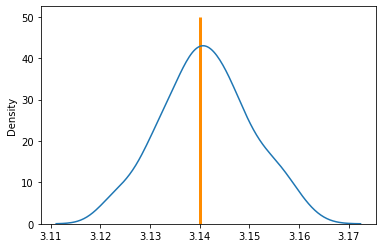

In [8]:
sims = 100
estimates = []
for i in range(sims):
    
    x = np.random.uniform(low = -1, high = 1, size = 10000)
    
    deterministic_computation = 4 * (1 - x ** 2) ** 0.5
    
    estimate = np.mean(deterministic_computation)
    estimates.append(estimate)
    
sns.kdeplot(estimates)
plt.vlines(3.14, ymin = 0, ymax = 50, color = 'darkorange', linewidth = 3)
plt.show()

In [7]:
np.mean(estimates)

3.141219101387876

### What is a Markov Chain?

A Markov Chain is a memoryless, stochastic process. In other words, to know where you're going, it doesn't matter where you've been, only where you are now. 

**Example**: Suppose you're considering investing in GME (GameStop). You want to model the price movements with a markov chain with the following transition matrix:

$$
\begin{bmatrix}
P(S_{t+1} = +1 |S_t = +1) & P(S_{t+1} = -1 |S_t = +1) \\
P(S_{t+1} = +1 |S_t = -1) &P(S_{t+1} = -1 |S_t = -1)
\end{bmatrix}
=
\begin{bmatrix}
0.25 & 0.75 \\
0.75 & 0.25 
\end{bmatrix}
$$

![](assets/markovchain.png)

If today is Monday and the stock went up a dollar today, what is the probability that the stock goes up a dollar on Wednesday at close?

In [10]:
up_to_down = 0.75
up_to_up = 0.25

down_to_up = 0.75
down_to_down = 0.25

up_to_down * down_to_up + up_to_up * up_to_up

0.625

If today is Monday and the stock went up a dollar today, what is the probability that the stock goes up a on this day a year from today?

An interesting, and desirable question: In the long-run, on any given day, what is the probability that the stock will go up a dollar? 

**Stationary Distribution:** $\pi = \pi T$

Here, our stationary distribution is $\pi = [0.5, 0.5]$

$$
[0.5, 0.5]
\begin{bmatrix}
0.25 & 0.75 \\
0.75 & 0.25 
\end{bmatrix}
=
[0.5, 0.5]
$$

In [3]:
from functools import reduce
mmult = lambda a, b: np.dot(a, b)

T = np.array([[0.25, 0.75],
              [0.75, 0.25]])

days = 365
Ts = [T for i in range(days)]
reduce(mmult, Ts)

array([[0.5, 0.5],
       [0.5, 0.5]])

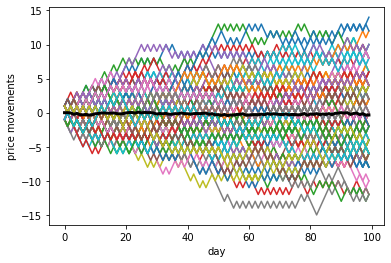

In [18]:
states = [1, -1]
iters = 100
days = 100

movements = np.zeros((iters, days))
cur_state = 0
T = np.array([[0.25, 0.75],
              [0.75, 0.25]])

for i in range(iters):
    for d in range(days):
        
        transition_probs = T[cur_state, ]
        
        next_state = np.random.choice([0, 1], p = transition_probs)
        
        movements[d, i] = states[next_state]
        
        cur_state = next_state


plt.plot(np.cumsum(movements, axis = 0))
plt.plot(np.average(np.cumsum(movements, axis = 0), axis = 1), linewidth = 3, color = "black")
plt.xlabel("day")
plt.ylabel("price movements")
plt.show()

### So what do Markov Chains and Monte Carlo methods have to do with Bayesian Inference?

### The Markov Chain component

How does randomly walking around the posterior actually guarantee that we will recover the true posterior? The key is that we construct a Markov chain with a stationary distribution equal to our posterior. Hence, if we walk around long enough, (hopefully) our Markov chain will converge to its unique stationary distribution and thus the posterior.

Unfortunately, we can't just alchemize any Markov chain to converge to our posterior, but it turns out that it's not all that difficult to conjure up the right Markov chain. Obviously, we need a stationary distribution to exist. Specifically, we need *unique* stationary distribution. (What good is an infinite number of stationary distributions?)

To achieve a unique stationary distribution we will ensure our Markov chain is **ergodic and reversible**.

### *Ergodicity*

**Irreducible:** In an irreducible Markov chain, each state is reachable from any other state, in a finite number of steps.

Recall our stock example: 

- The stock can go up after going down and vice versa in a finite number of days. 

**Aperiodic:** The number of steps to return to state $i$ is uncertain. 

Recall our stock example: 

- The stock could go up for 3 days before it goes down. Or it could go up for 4 days before it goes down, etc. There is no strict path that the stock follows with certainty.

### *Reversibility*

**This is where the magic happens.** A sufficient (but not neccessary) condition for the existence of a stationary distribution is reversibility (detailed balance). In other words, the probability of being in state $x$ and transitioning to state $y$ is the same as the probability of being in state $y$ and transitioning to state $x$.

$$\pi(x)T_{y, x} = \pi(y)T_{x, y}$$

Recall our stock example: 

Take $x = +1, y = -1$

$$\pi(+1)T_{-1, +1} = \pi(-1)T_{+1, -1}$$

$$0.5*0.75 = 0.5 * 0.75$$

While the discrete case is useful for pedagogical reasons, from here I will transition (no pun intended) to the continuous case, which looks virutally the same:

$$\pi(x)T(y|x) = \pi(y)T(x|y)$$

but now $\pi$ and $T$ are ***densities*** instead of matrices.

### Checkpoint:

**Big picture**: 

- We want to sample from our posterior $\pi^{*}$, but we can't ascertain $\pi^{*}$ analytically.

- Instead, intelligently construct a Markov chain and settle to sample from its stationary distribution $\pi = \pi^{*}$ as a substitute for our posterior.

- $\pi$ is the stationary distribution of some transition density $T$.

- We want to choose $T$ such that it converges to $\pi$. 

- Reversibility will give us such $T$

## DIY Markov Chain (with a unique stationary distribution)

1. Let your target density (your posterior) equal to the stationary distribution.
$$\pi^{*} = \pi$$

2. Ensure reversibility

$$\pi(x)T(y|x) = \pi(y)T(x|y)$$

The above equation is unlikely to hold. In other words, it could be the case that in reality,

$$\pi(x)T(y|x) \geq \pi(y)T(x|y)$$

Thus, we want to **impose a constraint such that the reversibility constraint is met**. 

3. Decompose $T(y|x) = g(y|x)A(y, x)$

where $g(y|x)$ is the conditional probability of proposing $y$ given we're in state $x$. $A(y, x)$ is the probability of accepting such a proposal. 

How does this help? Well suppose that we move from $x$ to $y$ more frequently than $y$ to $x$ (not reversible). How can we limit the moves from $x$?

We can introduce a **probability** that a move is made. $A(y, x) < 1$. If the proposal of moving to $y$ from $x$ is rejected, then we stay at $x$. 


4. Plug in the decomposition

$$\pi(x)g(y|x)A(y, x) = \pi(y)g(x|y)A(x, y)$$

This equation ensures balance!

5. Rearrange

$$\frac{A(y, x)}{A(x, y)} = \frac{\pi(y)g(x|y)}{\pi(x)g(y|x)}$$

6. Choose an acceptance ratio $\frac{A(y, x)}{A(x, y)}$

### Enter Metropolis-Hastings

We set $A(x, y) = 1$ since we want to increase those number of moves. 

$$A(y, x) = \min \bigg\{1, \frac{\pi(y)g(x|y)}{\pi(x)g(y|x)} \bigg\}$$

Furthermore, if we choose $g$, such that it is symmetric, we have the Metropolis Algorithm:

$$A(y, x) = \min \bigg\{1, \frac{\pi(y)}{\pi(x)} \bigg\}$$


All of that for one silly equation, huh

## From the top

Let's revisit the twitter bot example. Your friend observed one bot account and one authentic account, which yields the posterior:

$$\pi(p|X=1) \propto p(1-p)$$

Now, obviously we know what the full posterior is, but let's pretend we don't and instead randomly walk around it.

Let's choose a symmetric proposal distribution on the same domain as $p$

In [19]:
p_curr = 0.5

prop_posterior = lambda p: p * (1 - p)

samples = []
samples.append(p_curr)

steps = 10000

for i in range(steps):
    p_prop = np.random.uniform()
    
    acceptance_ratio = prop_posterior(p_prop) / prop_posterior(p_curr)
    
    if np.random.uniform() < acceptance_ratio:
        
        p_curr = p_prop
        
    samples.append(p_curr)
    

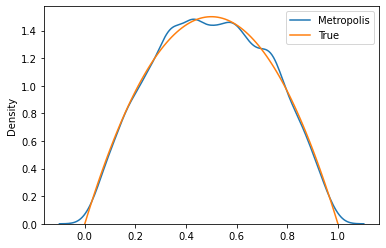

In [21]:
xx = np.linspace(0, 1, 100)
sns.kdeplot(samples, label = 'Metropolis')
plt.plot(xx, 6 * prop_posterior(xx), label = 'True')
plt.legend()
plt.show()

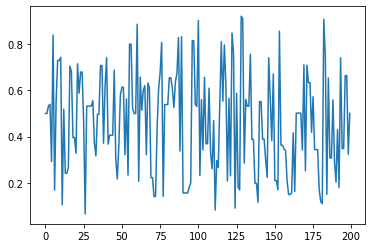

In [24]:
plt.plot(samples[:200])